In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import RobustScaler


In [22]:
train_df = pd.read_csv('data/train.csv')

#get equal amount of 1 and 0 targets
first_class = train_df[train_df['TARGET']==1].iloc[:2500,:]
zero_class = train_df[train_df['TARGET']==0].iloc[:2500,:]
train_df = pd.concat([zero_class, first_class])
train_df = shuffle(train_df)
train_df.drop('ID',axis=1,inplace=True)
# 1
print('train_df_shape = ',train_df.shape)

train_df_shape =  (5000, 370)


Delete columns with unique values less than 5%

In [23]:
non_unique_columns = []
for column in train_df.columns[:-1]:
    unique_percent = len(train_df[column].unique())/len(train_df)
    if unique_percent<0.1:
        non_unique_columns.append(column)
len(non_unique_columns)

355

In [4]:
train_df = train_df.drop(non_unique_columns,axis=1)

In [5]:
#In dataset we haven't nan values, so there is no need to fillna, but let it be)))
pct_null = (train_df.isnull().sum() / len(train_df)).sort_values(ascending=False)
pct_null[pct_null>0]
train_df = train_df.fillna(train_df.median())

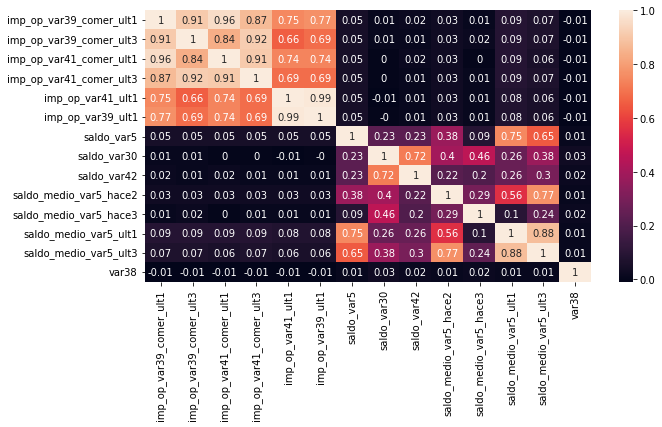

In [6]:
# Corr matrix
corr = train_df.iloc[:,:-1].corr()
corr = corr.round(2)

from matplotlib import rcParams
rcParams['figure.figsize'] = 10,5

sns.heatmap(corr, annot=True)
plt.show()

In [7]:
#correlation with target
target_corr = train_df.iloc[:,:-1].corrwith(train_df["TARGET"]).abs()
print(target_corr)

imp_op_var39_comer_ult1    0.026114
imp_op_var39_comer_ult3    0.007311
imp_op_var41_comer_ult1    0.028208
imp_op_var41_comer_ult3    0.014184
imp_op_var41_ult1          0.078065
imp_op_var39_ult1          0.076466
saldo_var5                 0.055114
saldo_var30                0.128041
saldo_var42                0.086566
saldo_medio_var5_hace2     0.069973
saldo_medio_var5_hace3     0.072568
saldo_medio_var5_ult1      0.062674
saldo_medio_var5_ult3      0.069821
var38                      0.077297
dtype: float64


Features' uniform histograms and boxplots due to target

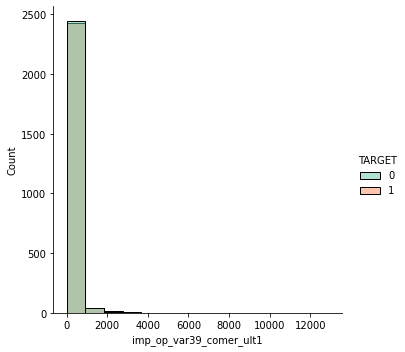

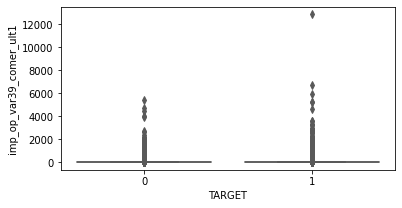

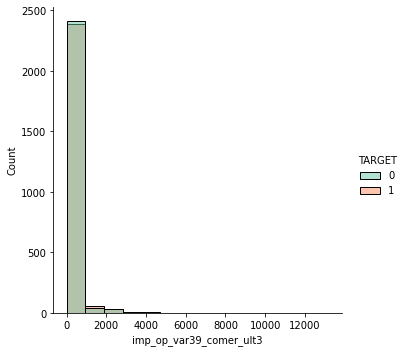

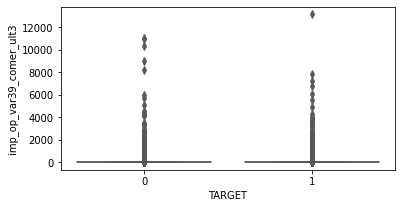

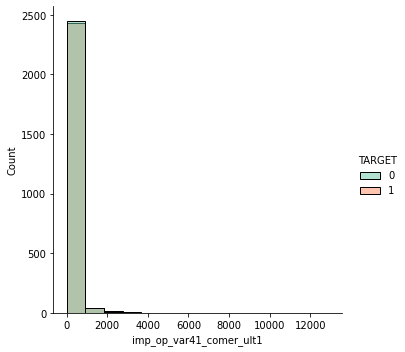

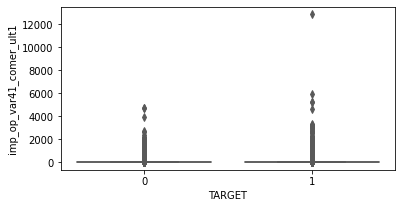

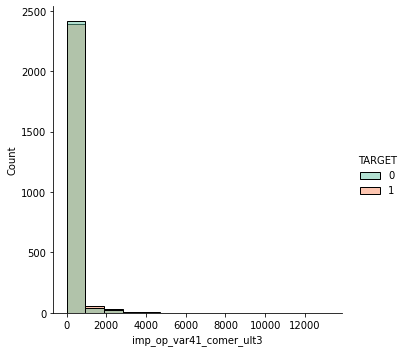

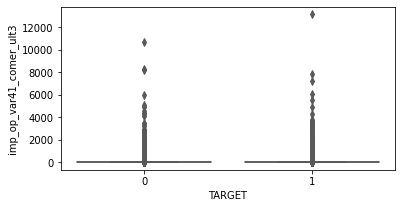

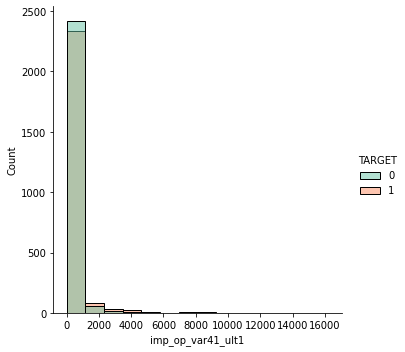

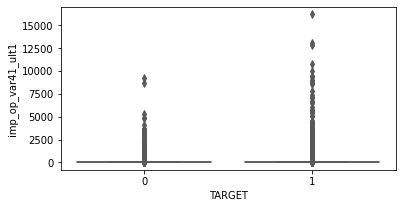

In [9]:

rcParams['figure.figsize'] = 6,3
for column in train_df.columns[:5]:
    sns.displot(data=train_df, x=column, hue="TARGET",palette="Set2")
    plt.show()
    sns.boxplot(data=train_df, x='TARGET', y=column, palette="Set2")
    plt.show()

In [10]:
# RobustScaler fit well, when we have outliers, which we don't want to remove. So it can scale our data despite them
robust_scaler = RobustScaler()
train_df.iloc[:,:-1] = robust_scaler.fit_transform(train_df.iloc[:,:-1])

In [11]:
Y_train=train_df.iloc[:,-1]
X_train=train_df.iloc[:,:-1]
print(X_train.shape)
print(Y_train.shape)

(5000, 14)
(5000,)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

ADA = AdaBoostClassifier()
KNN = KNeighborsClassifier()
DT = DecisionTreeClassifier()
RF = RandomForestClassifier()
SVM = SVC()

k_range = [1,3,5]
knn_param_grid = dict(n_neighbors = k_range)
svc_param_grid = {'C': [0.1, 2], 'gamma': [1,0.1]}
ada_param_grid = {
              'n_estimators':[50,200],
              'learning_rate':[0.01,0.1]
              }
rf_param_grid = { 
    'n_estimators': [25, 100],
    'max_depth' : [5,8],
}

skf = StratifiedKFold(n_splits=5)

def define_models(skf):
    gsADA = GridSearchCV(ADA,param_grid = ada_param_grid, cv=skf, scoring="f1_micro", n_jobs= 4, verbose = 1)
    gsKNN = GridSearchCV(KNN,param_grid = knn_param_grid, cv=skf, scoring="f1_micro", n_jobs= 4, verbose = 1)
    gsSVC = GridSearchCV(SVM,param_grid = svc_param_grid, cv=skf, scoring="f1_micro", n_jobs= 4, verbose = 1)
    gsRF = GridSearchCV(RF,param_grid = rf_param_grid, cv=skf, scoring="f1_micro", n_jobs= 4, verbose = 1)
    return gsADA, gsKNN, gsSVC, gsRF

gsADA, gsKNN, gsSVC, gsRF = define_models(skf)

DT_fit = DT.fit(x_train,y_train)
print("DT ready")
gsADA_fit = gsADA.fit(x_train,y_train)
print("ADA ready")
gsKNN_fit = gsKNN.fit(x_train,y_train)
print("KNN ready")
gsSVC_fit = gsSVC.fit(x_train,y_train)
print("SVC ready")
gsRF_fit = gsRF.fit(x_train,y_train)
print('RF ready')

DT ready
Fitting 5 folds for each of 4 candidates, totalling 20 fits
ADA ready
Fitting 5 folds for each of 3 candidates, totalling 15 fits
KNN ready
Fitting 5 folds for each of 4 candidates, totalling 20 fits
SVC ready
Fitting 5 folds for each of 4 candidates, totalling 20 fits
RF ready


Best params from each model

In [14]:
print("Random Forest best params = ",gsRF.best_params_)
print("Adaboost best params = ",gsADA.best_params_)
print("SVM best params = ",gsSVC.best_params_)
print("KNN best params = ",gsKNN.best_params_)

Random Forest best params =  {'max_depth': 8, 'n_estimators': 100}
Adaboost best params =  {'learning_rate': 0.1, 'n_estimators': 200}
SVM best params =  {'C': 2, 'gamma': 1}
KNN best params =  {'n_neighbors': 5}


In [15]:
from sklearn.metrics import f1_score

DT_prediction = DT_fit.predict(x_valid)
RF_prediction = gsRF_fit.predict(x_valid)
KNN_prediction = gsKNN_fit.predict(x_valid)
SVC_prediction = gsSVC_fit.predict(x_valid)
ADA_prediction = gsADA_fit.predict(x_valid)

print("DT score = ",f1_score(y_valid, DT_prediction, average='micro'))
print("RF score = ",f1_score(y_valid, RF_prediction, average='micro'))
print("KNN score = ",f1_score(y_valid, KNN_prediction, average='micro'))
print("SVC score = ",f1_score(y_valid, SVC_prediction, average='micro'))
print("ADAboost score = ",f1_score(y_valid, ADA_prediction, average='micro'))

DT score =  0.645
RF score =  0.7160000000000001
KNN score =  0.677
SVC score =  0.674
ADAboost score =  0.702


random forest model fit best

              precision    recall  f1-score   support

           0       0.67      0.75      0.71       457
           1       0.77      0.68      0.72       543

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



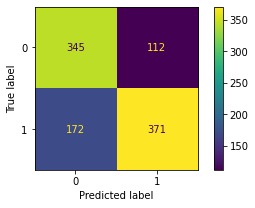

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_valid, RF_prediction, target_names=['0','1']))

cm = confusion_matrix(y_valid, RF_prediction, labels=gsRF_fit.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=gsRF_fit.classes_)
disp.plot()

plt.show()


Viz decision trees

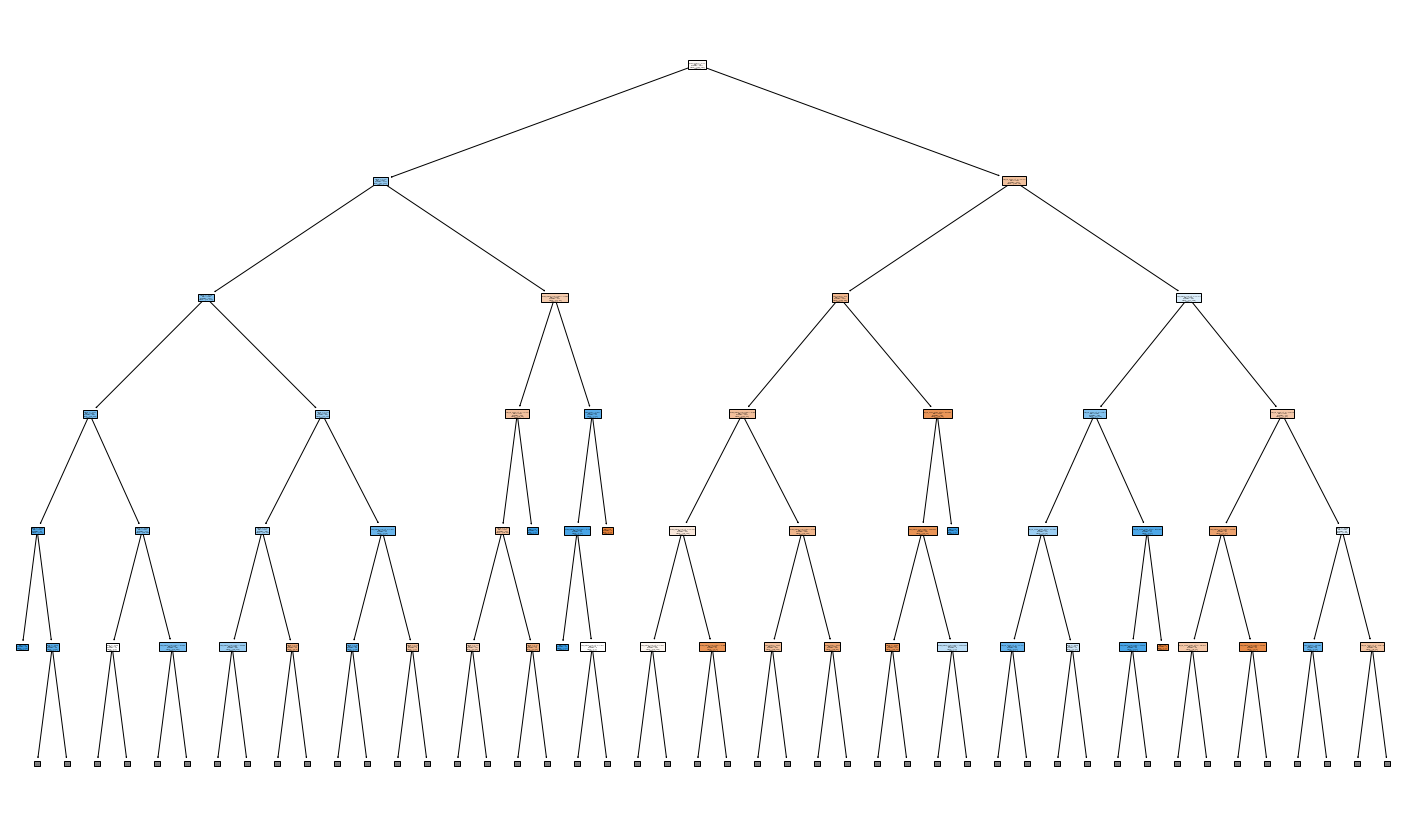

In [20]:
from sklearn import tree
rcParams['figure.figsize'] = 25,15
_ = tree.plot_tree(DT_fit, 
                   feature_names=X_train.columns,  
                   class_names=['0','1'],
                   filled=True,
                   max_depth = 5)